<a href="https://colab.research.google.com/github/czeacach/fashion_designers/blob/main/Copie_de_Copie_de_wdt_spatialisation_lieux_d'%C3%A9tudes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spatialisation des lieux d'études: analyse des données

## Introduction
Dans ce carnet nous explorons les données relatives aux lieux de formation des créateurs et créatrices de mode pour répondre aux questions suivantes:

* **(Vision synchronique) Quels sont les pays/ régions du monde où se forment/se sont le plus formé.e.s les créateurs.trices de mode?**

* **(Vision diachronique) Des pôles de formation se sont-ils dessinés à certaines périodes ? Si oui, où et quand ? Comment ont-ils évolués dans le temps?**

Pour ce faire, nous expérimentons différentes méthodes de spatialisation de l'information:

* la projection de points avec diamètre de longueur proportionnelle à l'effectif des objets représentés

* la représentation de polygones correspondants aux États contemporains avec gradient de couleur en fonction de l'effectif des individus nés dans cette région: cartes choroplèthes

* un affichage dynamique de l'évolution dans le temps utilisant la librairie Plotly Express


## Les SIG
* L’information géographique (attributs, relations spatiales, géométries)

* Les systèmes d'information géographique ou SIG : formes des géométries (du point à la 3D)

* Représentation de la réalité spatiale: géométries et données attributaires
Exemple: Corine Land Cover, base de données européenne d'occupation du sol, financée par la communauté européenne

In [121]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [122]:
### Noter qu'il faudra avoir installé toutes les librairies nécessaires
# dans l'environnement conda utilisé pour exécuter ce carnet
import pandas as pd
import geopandas as gpd
#from shapely.geometry import LineString
from geopandas.tools import sjoin
#import networkx as nx
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
#import seaborn as sns
import json
import IPython

In [123]:
### Librairies déjà installées avec Python
import pprint
import sqlite3 as sql
import sys
from importlib import reload
!pip install geodatasets
!pip install itables

In [124]:
from geodatasets import get_path
from itables import init_notebook_mode, show
import os

### Un premier affichage exploratoire
On utilise la librairie GeoPandas qui apporte de nombreuses fonctionnalités SIG

**Introduction à GeoPandas**

Noter que les données de Wikidata sont stockées au format WKT (Well Known Text), par ex. POINT (37.61778 55.75583), et que la librairie GeoPanas va les transformer en géométries (type de valeur Python spécifique)

### Se connecter à la base de données

In [125]:
# Chemin de la base de données dans Google Drive
db_path = "/content/drive/MyDrive/dossier de travail/fashion_designers_data_analysis.db"

# Connexion à la base de données SQLite
cn = sql.connect(db_path)
cn

In [126]:
### Préparer les données à afficher
# Il est plus simple d'effecture cette requête en SQL que dans Pandas
cur = cn.cursor()
l = cur.execute("""
SELECT organisation, organisationLabel, COUNT(*) eff, MAX(coordinates) geo_coord
FROM wdt_place_study
-- il y a des erreurs dans Wikidata
WHERE coordinates LIKE 'Point(%'
GROUP BY organisation, organisationLabel
-- exclut les valeurs vides
HAVING LENGTH(MAX(coordinates)) > 7
ORDER BY eff DESC
""").fetchall()
print(len(l))
l[:2]

1074


[('http://www.wikidata.org/entity/Q1339626',
  'Parsons School of Design',
  68,
  'Point(-73.994166666 40.735277777)'),
 ('http://www.wikidata.org/entity/Q1053996',
  'Central Saint Martins',
  56,
  'Point(-0.125 51.535555555)')]

In [127]:
### Créer un dataframe contenant le résultat
df_l = pd.DataFrame(l, columns=['placeUri', 'placeLabel', 'effectif', 'geoCoord'])
df_l.head(20)

,placeUri,placeLabel,effectif,geoCoord
0,http://www.wikidata.org/entity/Q1339626,Parsons School of Design,68,Point(-73.994166666 40.735277777)
1,http://www.wikidata.org/entity/Q1053996,Central Saint Martins,56,Point(-0.125 51.535555555)
2,http://www.wikidata.org/entity/Q844999,Fashion Institute of Technology,52,Point(-73.994166666 40.746666666)
3,http://www.wikidata.org/entity/Q1753535,Royal College of Art,27,Point(-0.178888888 51.501388888)
4,http://www.wikidata.org/entity/Q2746779,Royal Academy of Fine Arts,25,Point(4.4069 51.2234)
5,http://www.wikidata.org/entity/Q1627503,London College of Fashion,20,Point(-0.144 51.5152)
6,http://www.wikidata.org/entity/Q361395,Bunka Fashion College,19,Point(139.6945 35.68533333)
7,http://www.wikidata.org/entity/Q5436735,Fashion Institute of Design & Merchandising,17,Point(-118.259921 34.044252)
8,http://www.wikidata.org/entity/Q15274445,Saint Martin's School of Art,16,Point(-0.1299 51.5142)
9,http://www.wikidata.org/entity/Q273593,Beaux-Arts de Paris,14,Point(2.333277777 48.856805555)


In [128]:
### Tester la fonction qui exécute la conversion en géométrie
# Cf. excursus concernant le nettoyage ci-dessous
s = gpd.GeoSeries.from_wkt(df_l.geoCoord[:5])
s

0    POINT (-73.99417 40.73528)
1     POINT (-0.12500 51.53556)
2    POINT (-73.99417 40.74667)
3     POINT (-0.17889 51.50139)
4      POINT (4.40690 51.22340)
dtype: geometry

In [129]:
### Créer un dataframe geopandas avec une colonne contenant une géométrie
# https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html
study_gdf = gpd.GeoDataFrame(
    df_l[['placeUri', 'placeLabel', 'effectif']],\
    geometry=gpd.GeoSeries.from_wkt(df_l.geoCoord.to_list()), crs="EPSG:4326"
)

# On dispose ainsi du DataFrame GeoPandas avec la colonne indispensable 'geometry'
study_gdf.head(3)

,placeUri,placeLabel,effectif,geometry
0,http://www.wikidata.org/entity/Q1339626,Parsons School of Design,68,POINT (-73.99417 40.73528)
1,http://www.wikidata.org/entity/Q1053996,Central Saint Martins,56,POINT (-0.12500 51.53556)
2,http://www.wikidata.org/entity/Q844999,Fashion Institute of Technology,52,POINT (-73.99417 40.74667)


## Réalisation de la première carte ( synchronique)

In [130]:
### Inspection des données à afficher
study_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1074 entries, 0 to 1073
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   placeUri    1074 non-null   object  
 1   placeLabel  1074 non-null   object  
 2   effectif    1074 non-null   int64   
 3   geometry    1074 non-null   geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 33.7+ KB


In [131]:
### Datasets Geopandas pour la couche de base
gpd.datasets.available

['naturalearth_cities', 'naturalearth_lowres', 'nybb']

In [132]:
### Récupérer la carte de base, qui est aussi un DataFrame GeoPandas
world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)
world.head()

<ipython-input-132-9ef4baaeec50>:2: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


### La question du géoréférencement des géométries
Le géoide
Le système géodésique
Le système géodésique mondial WGS 84


In [133]:
### Types de géométries
pprint.pp(world.crs)
print('-------\n')
pprint.pp(study_gdf.crs)

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

-------

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich



### Cartographie de l'ensemble des lieux d'études des créateurs.trice de mode (vision synchronique)

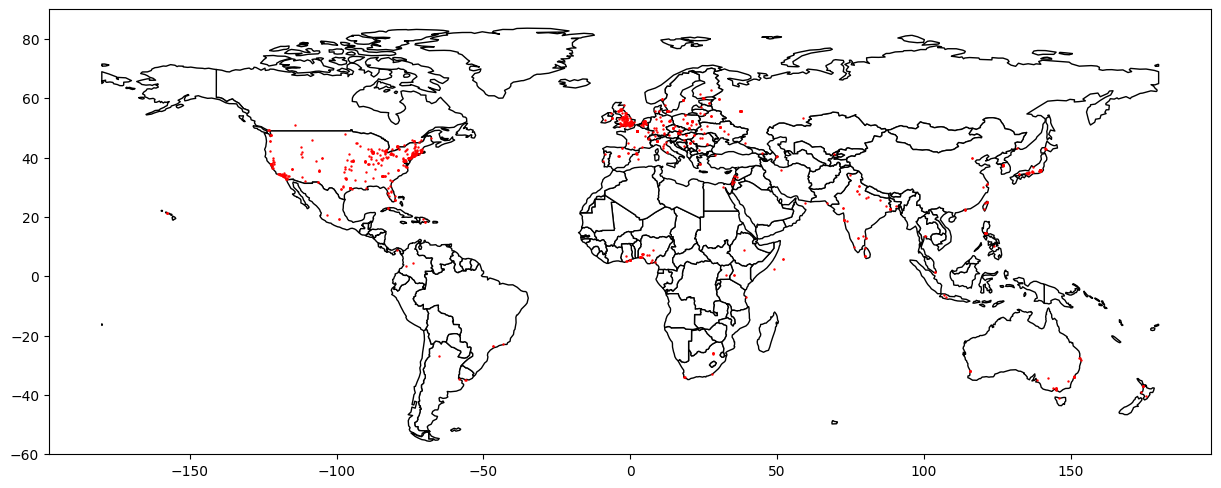

In [134]:
### Cartographier de toutes les lieux d'études des créateurs. trices de mode
# projection géographique

ax = world.plot(color="white", edgecolor="black", figsize=(15,10))

#ax.set_xlim([-0.1, 2])
ax.set_ylim([-60, 90])

# Noter que le diamètre du marqueur est fixe
study_gdf.plot(ax=ax, color="red", markersize=0.5)

plt.show()

### Commentaire
**On voit que les lieux d'études principaux des créateurs.trices de mode se trouvent majoritairement en Europe et aux Etats-Unis.**

La répartition en Europe est plus homogène que dans les autres continents, dans lesquels un ou deux pays dominent:

* En Amérique, il s'agit des Etats-Unis.

* En Asie, du Japon et également de l'Inde.

* En Afrique, il s'agit du Nigeria et du Ghana.

**Il est intéressant de remarquer que, indépendamment des pays et des continents, ces lieux d'études se concentrent plutôt aux frontières des Etats qu'à l'intérieur de ces derniers et se concentrent notamment sur les côtes maritimes.**

On peut se demander si cela est dû aux liens entre industrie textile et commerce maritime et donc à l'importance historique des villes portuaires?


### Focus sur les deux régions les plus représentées: l'Europe et les Etats-Unis

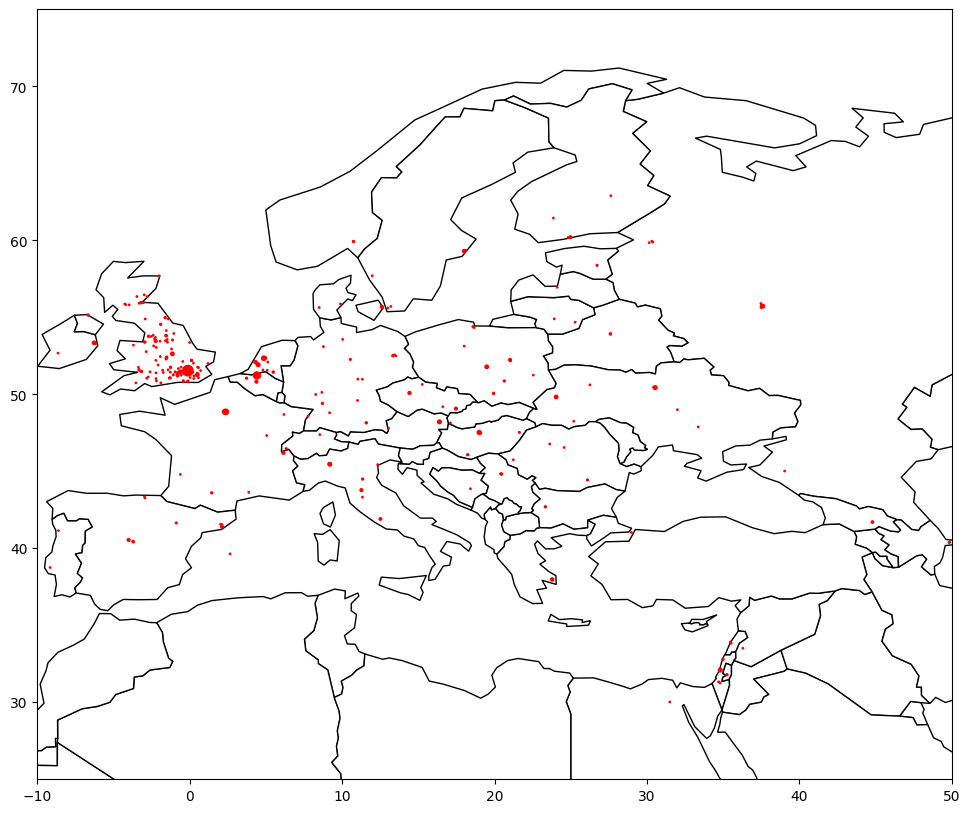

In [135]:
### Focus sur l'Europe à partir de la même carte
# On restreint les degrés longitude, latitude

ax = world.plot(color="white", edgecolor="black", figsize=(15,10))

# lon
ax.set_xlim([-10, 50])
# lat
ax.set_ylim([25, 75])

# Noter que le diamètre du marqueur est proportionnel aux effectifs du lieu
study_gdf.plot(ax=ax, color="red", markersize=study_gdf.effectif)

plt.show()

### Commentaire Europe

**On observe les lieux d'études par lesquels sont passé.e.s les créateurs et créatrices de mode sont particulièrement concentrés en Europe du Nord ( Royaume-Uni et Pays-Bas et Belgique)**. Dans ces pays, les centres sont les villes d'Anvers pour la Belgique, de Rotterdam et d'Amsterdam pour les Pays-Bas et de Londres pour le Royaume-Uni.

Les lieux d'études des créateurs.trices de mode au Royaume-Uni sont dispersés sur l'ensemble du territoire, contrairement aux autres pays d'Europe.

En ce qui concerne la France, les lieux d'études sont presques tous concentrés à Paris.

En ce qui concerne l'Italie, les lieux d'études sont plutôt concentrés dans le nord du pays ( Rome, Milan, Bologne, Florence)

Ainsi, outre les villes où l'on trouve de grands ports, les centres culturels importants sont également très représentés.

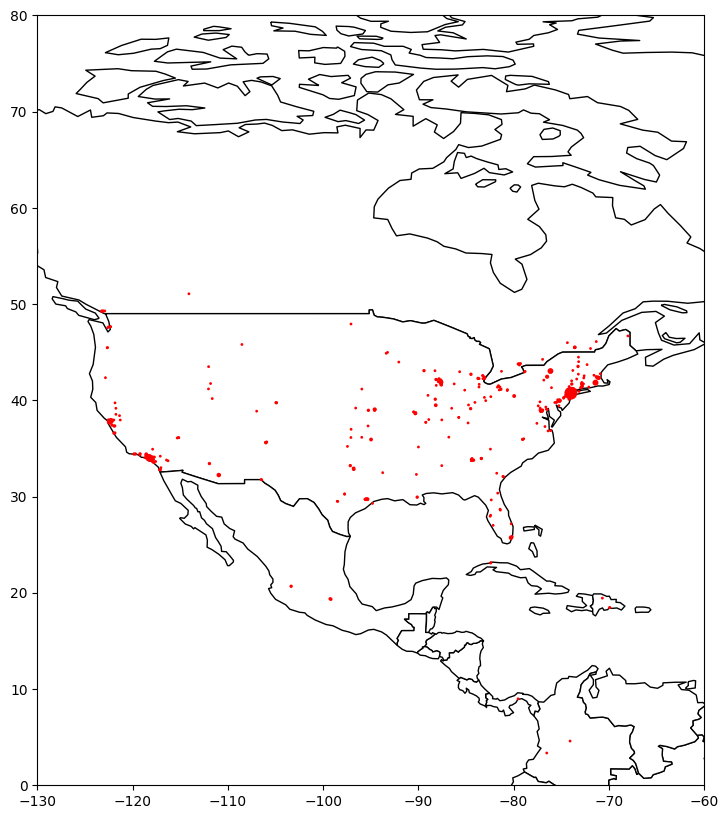

In [136]:
### Focus sur les Etats-Unis
# On restreint les degrés longitude, latitude

ax = world.plot(color="white", edgecolor="black", figsize=(15,10))

# lon
ax.set_xlim([-130, -60])
# lat
ax.set_ylim([0, 80])

# Noter que le diamètre du marqueur est proportionnel aux effectifs du lieu
study_gdf.plot(ax=ax, color="red", markersize=study_gdf.effectif)

plt.show()

### Commentaire Etats-Unis

Les lieux de formations des créateurs et créatrices de mode sont répartis de manière peu homogène sur l'ensemble du territoire.

**Ils se concentrent plutôt à l'Est, et principalement sur les deux côtes: surtout au Nord de la côte Est où New York et particulièrement dominant. Sur la côte Ouest, les centres sont Los Angeles et San Francisco.**



In [137]:
### Transformation de la géographie
# vers une géométrie projetée: Web Mercator (EPSG 3857)
# Google Maps Global Mercator (EPGS 900913)

## Démarche effectuée à titre illustratif ici:
# indispensable si on utilise des données spatiales nationales
# qui sont dans des coordonnées et projections spatiales propres



### https://en.wikipedia.org/wiki/Web_Mercator_projection

prj_world = world.copy(deep=True)
prj_world.geometry = prj_world.geometry.to_crs(900913)
pprint.pp(prj_world.crs)
print('------')
prj_study_gdf = study_gdf.copy(deep=True)
prj_study_gdf.geometry = prj_study_gdf.geometry.to_crs(900913)
pprint.pp(prj_study_gdf.crs)

<Projected CRS: EPSG:900913>
Name: Google Maps Global Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

------
<Projected CRS: EPSG:900913>
Name: Google Maps Global Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich



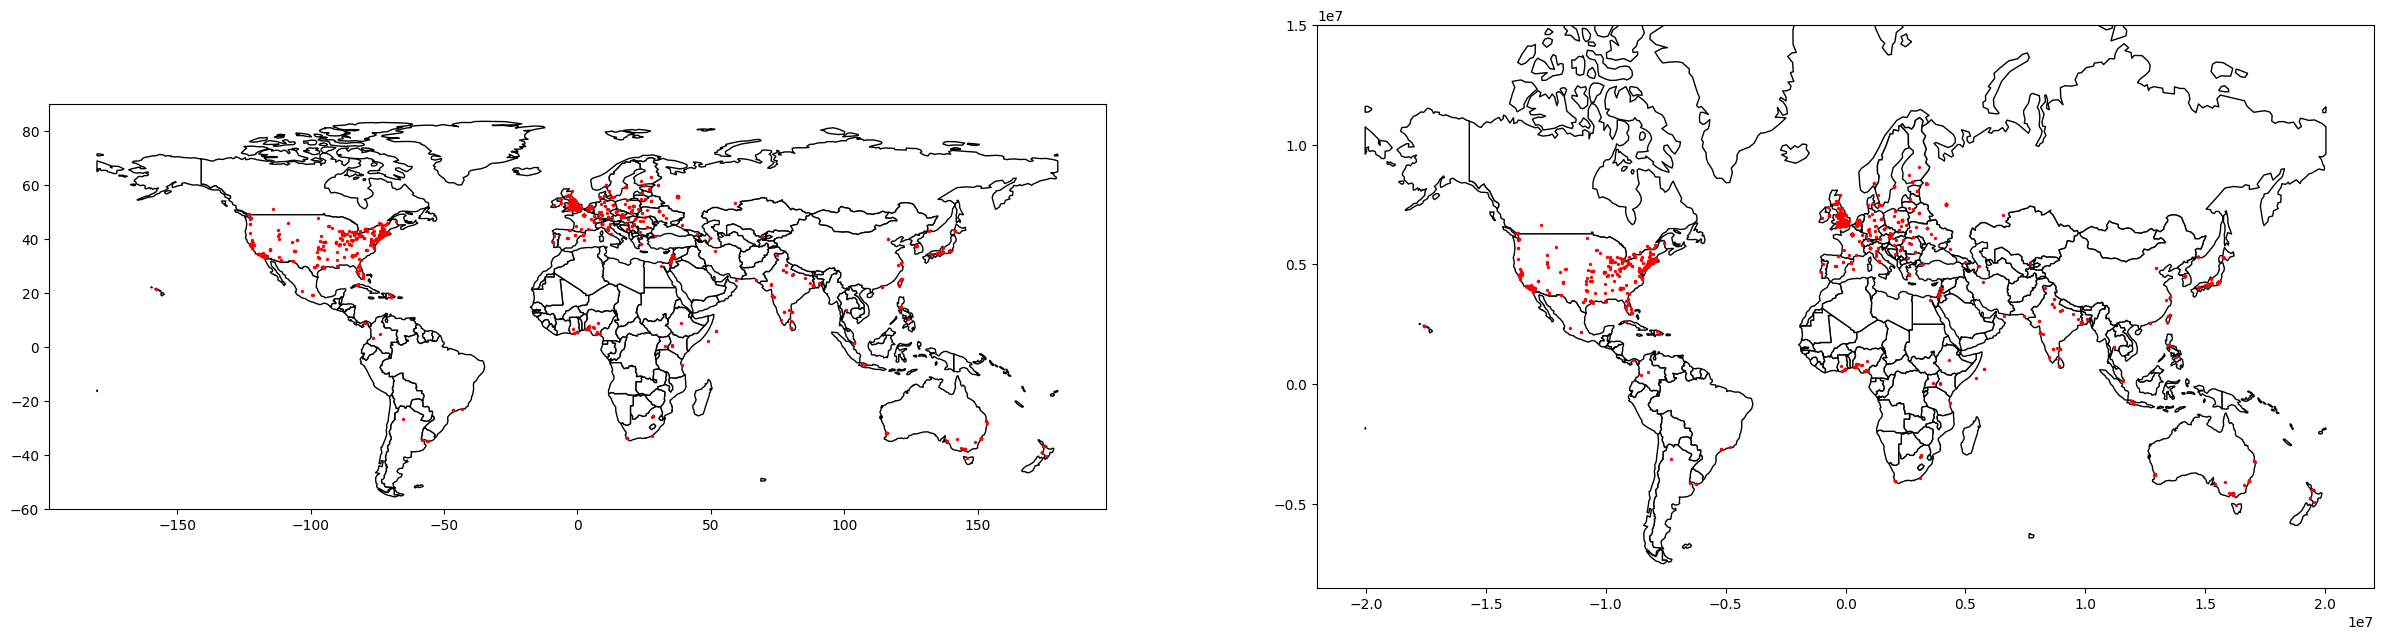

In [138]:
### Cartographier tous les lieux d'études des personnes
# avec deux systèmes de projection différents:
# géographique à gauche, Global Mercator à droite

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,20))

ax1 = world.plot(color="white", ax=axes[0], edgecolor="black")
#ax.set_xlim([-0.1, 2])
ax1.set_ylim([-60, 90])

study_gdf.plot(ax=axes[0], color="red", markersize=2)

ax2 = prj_world.plot(color="white", ax=axes[1], edgecolor="black")
#ax.set_xlim([-0.1, 2])
ax2.set_ylim([-8.5*10e5, 1.5*10e6])

prj_study_gdf.plot(ax=axes[1], color="red", markersize=2)

plt.show()

## Affichage dynamique en relation avec les périodes
On teste ici un affichage dynamique avec la librairie Plotly express

In [139]:
### Préparer les données à afficher:
# on ne les regroupe pas encore afin de coder les périodes
cur = cn.cursor()
l = cur.execute("""
SELECT birthYear,organisation, organisationLabel, coordinates AS geo_coord
FROM wdt_place_study
-- il y a des erreurs dans Wikidata
WHERE coordinates LIKE 'Point(%'
""").fetchall()

df_all = pd.DataFrame(l, columns=['birthYear','placeUri', 'placeLabel', 'geo_coord'])
print(len(df_all))
df_all.head()


2019


,birthYear,placeUri,placeLabel,geo_coord
0,1832,http://www.wikidata.org/entity/Q414052,"Academy of Fine Arts, Munich",Point(11.580312391 48.15319592)
1,1832,http://www.wikidata.org/entity/Q658192,Vilnius University,Point(25.287222222 54.6825)
2,1868,http://www.wikidata.org/entity/Q481762,École normale supérieure de jeunes filles,Point(2.33131 48.8224)
3,1876,http://www.wikidata.org/entity/Q1135990,École nationale supérieure des arts décoratifs,Point(2.345 48.84278)
4,1877,http://www.wikidata.org/entity/Q877686,University of Applied Arts Vienna,Point(16.382219444 48.208419444)


### Coder les données avec les périodes

In [140]:
### Préparer la liste des périodes
l2 = list(range(1801, 2002, 25)) # générations
print(l2)

[1801, 1826, 1851, 1876, 1901, 1926, 1951, 1976, 2001]


In [141]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_all['birthYear'] = df_all['birthYear'].astype(int)
df_all['generations'] = pd.cut(df_all['birthYear'], l2, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_all['generations'] = df_all['generations'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_all.head(3)

,birthYear,placeUri,placeLabel,geo_coord,generations
0,1832,http://www.wikidata.org/entity/Q414052,"Academy of Fine Arts, Munich",Point(11.580312391 48.15319592),1826-1850
1,1832,http://www.wikidata.org/entity/Q658192,Vilnius University,Point(25.287222222 54.6825),1826-1850
2,1868,http://www.wikidata.org/entity/Q481762,École normale supérieure de jeunes filles,Point(2.33131 48.8224),1851-1875


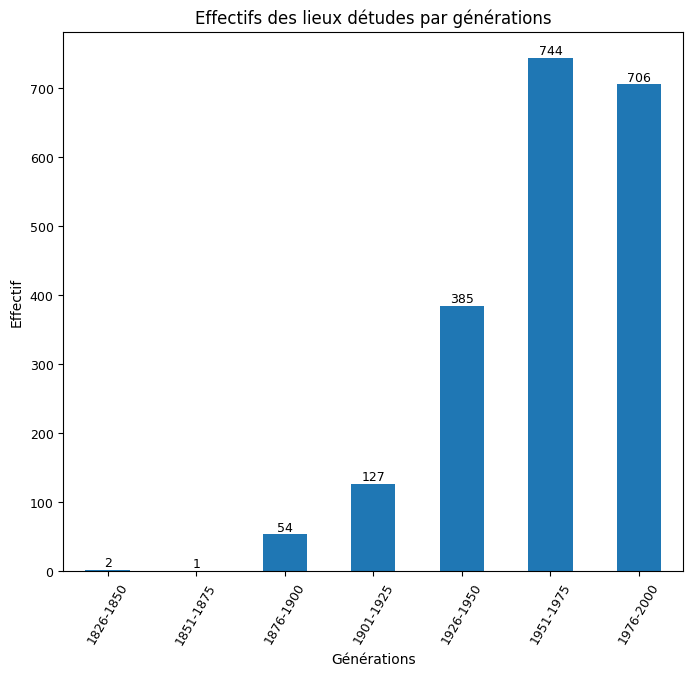

In [142]:
ax = df_all.groupby(by='generations', observed=True).size().plot(kind='bar',
                                            rot=60, fontsize=9, figsize=(8,7))
ax.bar_label(ax.containers[0], fontsize=9)
plt.ylabel('Effectif')
plt.xlabel('Générations')
plt.title('Effectifs des lieux détudes par générations')
plt.show()

### Commentaires

Les effectifs des lieux d'études des créateurs et créatrices de mode sont peu homogène pour la période étudiée (population née entre 1826-2000).

**On constate une augmentation nette après la Seconde Guerre mondiale. Cela pourait s'expliquer par le changement des modes de consommations pendant les Trentes glorieuses et donc une demande supérieure en vêtements et donc la création de formations spécifiques?**

Toutefois, il faudrait faire un travail de classement des établissements de formation par classe pour s'en assurer, car plusieurs d'entre eux relèvent du domaine des arts et pas nécessairement de l'industrie.

On peut aussi penser à une démocratisation générale des études après la Seconde Guerre mondiale.

**Pour le 19e siècle, il ne faut pas oublier que les données de notre populatation est certainement incomplète et que les lieux de formation des créateurs.trices de mode ne sont pas nécessairement renseignés, d'autant plus qu'il s'agissait probablement d'autres formes de formation, plutôt sous la forme d'un apprentissage chez un tailleur ou une couturière.**

In [143]:
### Créer une nouvelle table contenant le DataFrame
# Si on tente de la recréer, alor qu'elle existe déjà,
# un message d'erreur est renvoyé
try:
    l = df_all[['generations', 'placeUri', 'placeLabel', 'geo_coord']]\
             .to_sql(name='wdt_generations_study_place', con=cn, if_exists='fail')
except Exception as e:
    print('Erreur: ',  e)

Erreur:  Table 'wdt_generations_study_place' already exists.


### Grouper et compter

On passe par la base de données parce que c'est plus simple qu'utiliser directement Pandas.

Noter que désormais ce sont les naissances (regroupées en périodes), et leur effectif, qui sont la variable étudiée

In [144]:
q1 = """
SELECT generations, placeLabel, geo_coord, COUNT(*) as effectif
FROM wdt_generations_study_place
GROUP BY generations, placeUri, placeLabel, geo_coord
"""
### Préparer les données à afficher
cur = cn.cursor()
l = cur.execute(q1).fetchall()
print(len(l))
l[:2]

1346


[('1826-1850',
  'Academy of Fine Arts, Munich',
  'Point(11.580312391 48.15319592)',
  1),
 ('1826-1850', 'Vilnius University', 'Point(25.287222222 54.6825)', 1)]

In [145]:
### Préparation des données à afficher dans Plotly Express
# ici on utilisé les coordonnées géographiques
df_gen_gr = pd.DataFrame(l, columns=['periode', 'lieu', 'geo_coord', 'eff'])
df_gen_gr.geo_coord = df_gen_gr.geo_coord.apply(lambda x: x.replace('Point(', '')\
                                .replace(')',''))
df_gen_gr['long'] = df_gen_gr.geo_coord\
    .apply(lambda x: round(float((x.split(' ')[0])), 4))
df_gen_gr['lat'] = df_gen_gr.geo_coord\
    .apply(lambda x: round(float((x.split(' ')[1])), 4))

df_gen_gr.head()

,periode,lieu,geo_coord,eff,long,lat
0,1826-1850,"Academy of Fine Arts, Munich",11.580312391 48.15319592,1,11.5803,48.1532
1,1826-1850,Vilnius University,25.287222222 54.6825,1,25.2872,54.6825
2,1851-1875,École normale supérieure de jeunes filles,2.33131 48.8224,1,2.3313,48.8224
3,1876-1900,Althin's School of Painting,18.084953333 59.334046666,1,18.0850,59.3340
4,1876-1900,Howard University,-77.02 38.921666666,1,-77.0200,38.9217


### Carte à points représentant l'évolution des lieux d'études

In [146]:
### Création de la carte interactive
# https://plotly.com/python/animations/
# https://plotly.com/python/scatter-plots-on-maps/

# np.log(s) * 1000
size = [s if s != 0 else 0 for s in df_gen_gr.eff]

fig = px.scatter_geo(
    df_gen_gr,
    lat="lat",
    lon="long",
    size=size,
    hover_name = "lieu",
    animation_frame="periode",
    width=1400, height=600,
    color_discrete_sequence=['red'],
    title="Evolution des lieux détudes"
).update_layout(
        margin={"l": 0, "r": 20, "t": 30, "b": 0}
)

# On peut ici augmenter la durée des étapes
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1500

### Noter qu'on enregistre l'image afin de pouvoir l'ouvrir dans un navigateur
# et l'inspecter sans exécuter le code Python du carnet

# Vérification et création du répertoire 'images' si nécessaire
os.makedirs('images', exist_ok=True)

# Chemin de l'image à enregistrer
f_address = "images/study_places_points.html"
fig.write_html(f_address)

#fig.show()


### Commentaire carte à point (évolution des lieux d'études) (vision diachronique)

**(Génération née entre 1876-1900 --> Etudes env. 1886 et 1920)**

On remarque qu'à la fin du 19e siècle les pôles de formation se trouvaient en Europe centrale, à Paris et à Vienne, deux centres importants pour les avant-gardes artistiques à cette époque, on peut donc se demander s'il y a un lien avec la formations des créateurs et créatrices de mode.

**(Période 1901-1925--> Etudes env. 1921 et 1945)**

On remarque que les Etats-Unis et New-York plus spécifiquement deviennent un pôle majeur de formation par lequel passent les créateurs et créatrices de mode. On dénombre quelques lieux de formation en Asie, et plus spécifiquement au Japon.

**(Période 1926-1950 --> Etudes env. 1946-1970)**

Durant cette période, on observe que l'Europe du Sud et de l'Est deviennent des régions de formation pour les créateurs et créatrices de mode. Le Moyen-Orient émerge également comme nouveau lieu de formation et en Asie, l'Inde, ce qui peut s'expliquer par l'Indépendance de l'Inde et la création de l'Etat d'Israël. Le Japon s'affirme comme pôle de formation après la Seconde Guerre mondiale.

**(Période 1951-1975 --> Etudes env. 1971-1995)**

Pour la génération des créateurs et créatrices de mode né.e.s après la Seconde Guerre mondiale, l'Europe du Nord (Royaume-Uni, Belgique, Pays-Bas) émerge comme pôle majeur de la formation.

Quelques lieux de formation commencent d'apparaitre en Afrique, en Amérique latine et en Océanie.

**(Période 1976-2000 --> Etudes env. 1996-2020)**

Pour cette génération deux nouveaux pôles de formation émergent: la côte Ouest de l'Afrique ( Nigeria et Ghana) et la côte Ouest des Etats-Unis. Les principaux pôles de formation restent l'Europe du Nord et la côte Est des Etats-Unis.








Grouper et compter les institutions d'études par État contemporain

In [147]:
### Polygones des États contemporains
print(len(world))
world.head()

177


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [148]:
world_s = world[['name','geometry']].copy(deep=True)
world_s

,name,geometry
0,Fiji,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,Tanzania,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,W. Sahara,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Canada,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,United States of America,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...
172,Serbia,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,Montenegro,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,Kosovo,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,Trinidad and Tobago,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [149]:
### Transformer les coordonnées géogr. en points
df_gen_gr_gdf = gpd.GeoDataFrame(
    df_gen_gr[['periode', 'lieu', 'eff']],\
    geometry=gpd.points_from_xy(df_gen_gr.long, df_gen_gr.lat), crs="EPSG:4326"
)

df_gen_gr_gdf.head(3)

,periode,lieu,eff,geometry
0,1826-1850,"Academy of Fine Arts, Munich",1,POINT (11.58030 48.15320)
1,1826-1850,Vilnius University,1,POINT (25.28720 54.68250)
2,1851-1875,École normale supérieure de jeunes filles,1,POINT (2.33130 48.82240)


In [150]:
### Vérification
df_gen_gr_gdf.loc[df_gen_gr_gdf['lieu']=='Vilnius University']

,periode,lieu,eff,geometry
1,1826-1850,Vilnius University,1,POINT (25.28720 54.68250)


### Préparation de la fonction qui va créer les données à afficher

In [151]:
# https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin.html
# https://stackoverflow.com/questions/69644523/count-points-in-polygon-and-write-result-to-geodataframe


dfa = world_s.copy(deep=True)
dfb = df_gen_gr_gdf[df_gen_gr_gdf.periode == '1926-1950']

### jointure spatiale
dfc =  gpd.sjoin(dfb, dfa).groupby("name").sum(numeric_only=True)
dfa = dfa.join(dfc, on='name', how="left")
dfa.eff.fillna(value=0, inplace=True)
dfa['eff'] = dfa['eff'].astype(int)

dfa = dfa.assign(periode = '1926-1950')

dfa[dfa.eff > 0].sort_values(by='eff', ascending=False).head()

,name,geometry,eff,index_right,periode
4,United States of America,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",129,372.0,1926-1950
143,United Kingdom,"MULTIPOLYGON (((-6.19788 53.86757, -6.95373 54...",64,6292.0,1926-1950
155,Japan,"MULTIPOLYGON (((141.88460 39.18086, 140.95949 ...",36,3720.0,1926-1950
43,France,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...",36,645.0,1926-1950
141,Italy,"MULTIPOLYGON (((10.44270 46.89355, 11.04856 46...",12,1269.0,1926-1950


In [152]:
### Transformer en json pour afficher dans Plotly Express
countries_polygons = dfa[['name', 'geometry']]
countries_polygons.index = countries_polygons['name']
countries_polygons = countries_polygons.drop(['name'], axis=1)
countries_polygons_json = json.loads(countries_polygons.to_json())

In [153]:
### Représenter la densité de naissances de créateurs de mode par lieux d'études
# uniquement pour une période donnée
# https://plotly.com/python/animations/
# https://plotly.com/python-api-reference/generated/plotly.express.choropleth_mapbox.html
# https://medium.com/@lucas_bromerchenkel/choropleth-maps-with-time-sliders-using-plotly-df6e19e5f90c

# np.log(s) * 1000
size = [s if s != 0 else 0 for s in dfa.eff]

fig = px.choropleth_mapbox(
    dfa,
    geojson=countries_polygons_json,
    locations="name",
    color="eff",
    mapbox_style='white-bg',
    zoom=1,
    color_continuous_scale='blues',
    ### valeur  définie en fonction de la distribution par pays
    # expérimenter en changeant la valeur
    range_color=(1, 50),
    width=1000, height=600,
    title="Densité de naissance de créateurs de mode par lieux détudes période (1926-1950)"
)

#fig.show()

# Chemin de l'image à enregistrer
f_address = "density_map.html"

# Enregistrez l'image au format HTML
fig.write_html(f_address)

In [154]:
### Créer la liste des périodes
lp = df_gen_gr.groupby(by='periode').size().index.to_list()
lp

['1826-1850',
 '1851-1875',
 '1876-1900',
 '1901-1925',
 '1926-1950',
 '1951-1975',
 '1976-2000']

In [155]:
### Créer la liste des périodes
### les effectifs des lieux d'études renseignés étant très réduits jusqu'à 1875
 ### on réduit la liste à la période commençant par 1876
lp = ['1876-1900','1901-1925','1926-1950','1951-1975','1976-2000']
lp

['1876-1900', '1901-1925', '1926-1950', '1951-1975', '1976-2000']

In [156]:
### Préparer les données, un DataFrame avec jointure spatiale
# par période
frames=[]
for e in lp:

    dfa = world_s.copy(deep=True)
    dfb = df_gen_gr_gdf[df_gen_gr_gdf.periode == e]

    ### jointure spatiale
    dfc =  gpd.sjoin(dfb, dfa).groupby("name").sum(numeric_only=True)
    dfa = dfa.join(dfc, on='name', how="left")
    dfa.eff.fillna(value=0, inplace=True)
    dfa['eff'] = dfa['eff'].astype(int)

    dfa = dfa.assign(periode = e)

    frames.append(dfa)


### Concaténation des DataFrames
df_result = pd.concat(frames)
df_result=df_result.reset_index()
df_result.tail()

,index,name,geometry,eff,index_right,periode
880,172,Serbia,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",3,344.0,1976-2000
881,173,Montenegro,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",0,NaN,1976-2000
882,174,Kosovo,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",0,NaN,1976-2000
883,175,Trinidad and Tobago,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",0,NaN,1976-2000
884,176,S. Sudan,"POLYGON ((30.83385 3.50917, 29.95350 4.17370, ...",0,NaN,1976-2000


In [157]:
### inspection des données pour un pays
df_result[df_result.name=='France']

,index,name,geometry,eff,index_right,periode
43,43,France,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...",9,215.0,1876-1900
220,43,France,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...",9,301.0,1901-1925
397,43,France,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...",36,645.0,1926-1950
574,43,France,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...",33,817.0,1951-1975
751,43,France,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...",23,559.0,1976-2000


In [158]:
### Transformer en json pour affichage dans Plotly
countries_polygons = df_result[['name', 'geometry']]
countries_polygons.index = countries_polygons['name']
countries_polygons = countries_polygons.drop(['name'], axis=1)
countries_polygons_json = json.loads(countries_polygons.to_json())

### Carte choroplèthe représentant l'évolution des lieux d'études des créateurs.trices de mode par pays

In [159]:
### Représenter la densité de lieux d'études des créateur de mode par pays
# carte interactive.
# Noter que l'exécution peutprendre quelques minutes

# https://plotly.com/python/animations/
# https://plotly.com/python-api-reference/generated/plotly.express.choropleth_mapbox.html
# https://medium.com/@lucas_bromerchenkel/choropleth-maps-with-time-sliders-using-plotly-df6e19e5f90c

# np.log(s) * 1000
size = [s if s != 0 else 0 for s in df_result.eff]

fig = px.choropleth_mapbox(
    df_result,
    geojson=countries_polygons_json,
    locations="name",
    color="eff",
    mapbox_style='white-bg',
    zoom=1,
    color_continuous_scale='blues',
    ### valeur 20 définie en fonction de la distribution par pays
    # expérimenter en changeant la valeur
    range_color=(1, 50),
    animation_frame="periode",
    width=1000, height=600,
    title="Evolution des lieux détudes des créateurs.trices de mode par pays"
).update_layout(
    #mapbox={"style": "carto-positron", "zoom":10},
    margin={"l": 0, "r": 0, "t": 30, "b": 0}
)

fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1000

### Noter qu'on enregistre l'image afin de pouvoir l'ouvrir dans un navigateur
# et l'inspecter sans exécuter le code Python du carnet
f_address = "images/study_places_choropleth.html"
fig.write_html(f_address)

#fig.show()

### Commentaire de l'évolution des lieux d'études par pays

On remarque que les Etats-Unis sont le pays où la plupart des créateurs.trices de mode se forment dans l'ensemble des périodes. Ceci est lié aux propriétés de la population. En effet, l'analyse des nationalités à montré que le principal pays de citoyenneté des créateurs.trices de mode est les Etats-Unis.

De même, **on observe, à l'exception de l'Italie, que les pays où étudient le plus souvent les créateurs/trices de mode  ( Etats-Unis, France, Royaume-Uni, Japon ) sont les pays de nationalité les plus fréquentes des créateurs.trices de mode.**

De même, à l'exception de l'Italie, les pays où se trouvent les capitales actuelles de la mode (Paris, New-York, Londres et Milan) font partie des lieux d'études principaux des créateurs/trices de mode.

